In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/RunML_model

/content/drive/MyDrive/RunML_model


In [6]:
%%capture
!pip install netCDF4
!pip install einops


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import r2_score as R2
from scipy.io import savemat, loadmat

%load_ext autoreload
%autoreload 2
from netCDF4 import Dataset
from iostats import *

import torch.nn  as nn
import torch.nn.functional as F
from netCDF4 import Dataset
import pandas as pd
from tqdm import tqdm
from NNarch import ResMLP
import copy

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


In [9]:
import xarray as xr
alberto_file = "/content/drive/MyDrive/RunML_model/Data/processed_data/ml_ready/final.nc"
nc = xr.open_dataset(alberto_file)
df = nc.to_dataframe()
df_test = df

In [10]:
import xarray as xr
mashayek_file = "/content/drive/MyDrive/RunML_model/Data/Mashayek2022/input_microstructure.pkl"
pickle = pd.read_pickle(mashayek_file)
#df2 = pickle.to_dataframe()

In [11]:
# Rename columns using the rename() method
pickle = pickle.rename(columns={'log_N2_sort': 'LN2', 'log_kappa': 'LK', 'latitude': 'lat', 'z': 'Z'})

In [12]:
# Convert the dataset to a dataframe and group by the profile dimension
df = nc.to_dataframe().groupby('profile').apply(lambda x: x.reset_index(drop=True))
# make both profile and depth dimensions rows
df = df.reset_index()

In [13]:
# drop rows where NaN values are present only in "T" and "salinity" columns
df = df.dropna(subset=['T', 'S', 'eps'], how='all')
df

,profile,level_1,insituT,S,eps,longitude,latitude,year,time,P,...,T,rho,drhodz,depsdz,N2,kappa,log_N2,log_kappa,dTdz,dSdz
9,0,9,1.6460,29.8370,9.530000e-06,125.894433,76.73345,2007,259.785417,NaN,...,1.645644,1023.793962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0,10,1.6500,29.8610,5.081000e-05,125.894433,76.73345,2007,259.785417,NaN,...,1.649604,1023.817611,0.046235,-8.525000e-07,-519.665866,-1.955487e-08,NaN,NaN,0.229187,0.07025
11,0,11,2.1045,29.9775,7.825000e-06,125.894433,76.73345,2007,259.785417,NaN,...,2.104018,1023.886432,0.057870,-2.473500e-05,-22.415920,-6.981645e-08,NaN,NaN,0.253932,0.08700
12,0,12,2.1580,30.0350,1.340000e-06,125.894433,76.73345,2007,259.785417,NaN,...,2.157467,1023.933351,0.023562,-2.370000e-06,-95.250353,-2.813638e-09,NaN,NaN,0.123691,0.03425
13,0,13,2.3520,30.0460,3.085000e-06,125.894433,76.73345,2007,259.785417,NaN,...,2.351401,1023.933557,0.053982,-1.825000e-07,-2833.879611,-2.177227e-10,NaN,NaN,0.027450,0.06425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24213,350,63,3.9418,35.1101,5.734200e-07,9.366250,76.75140,2007,NaN,NaN,...,3.937456,1028.041430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24215,350,65,3.9408,35.1081,8.084600e-07,9.366250,76.75140,2007,NaN,NaN,...,3.936318,1028.049245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24216,350,66,3.9368,35.1054,6.432800e-07,9.366250,76.75140,2007,NaN,NaN,...,3.932251,1028.052180,0.004151,7.033200e-07,56.316885,2.284501e-09,1.750639,-8.641209,-0.008465,-0.00175
24217,350,67,3.9240,35.1046,2.215100e-06,9.366250,76.75140,2007,NaN,NaN,...,3.919388,1028.057547,0.007024,-7.342000e-08,-912.884734,-4.852968e-10,NaN,NaN,-0.017710,0.00065


In [14]:
# Rename columns using the rename() method
df = df.rename(columns={'log_N2': 'LN2', 'log_kappa': 'LK', 'latitude': 'lat', 'level_1': 'Z'})

In [15]:
# Identify rows with infinite or NaN values in the col column
mask = np.logical_or(np.isnan(df['N2']), np.isinf(df['kappa']))

# Remove rows with infinite or NaN values from the dataframe
df = df.loc[~mask]

## Do same adjustments as in Mashayek 2022


In [16]:
df.loc[df['N2'] <= 0, 'N2'] = np.nan

In [31]:
df = df.assign(LN2=np.log10(df['N2']))

In [32]:
df = df.assign(log_eps=np.log10(df['eps']))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


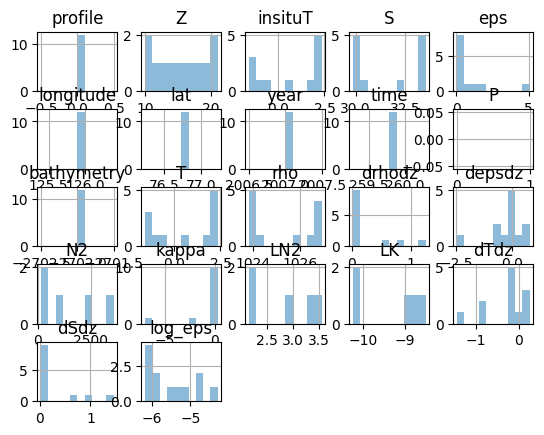

In [33]:
# Plot histograms for all columns in the dataframe
df[:12].hist(bins=10, alpha=0.5)
plt.show()

# Train on global, test on alberto ds

In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Fit the scaler to the columns to be normalized
# scaler.fit(df[['hab', 'S', 'T', 'dSdz', 'dTdz', 'LN2', 'N2', 'lat', 'Z']])
# add hab later
scaler.fit(pickle[['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2', "LK", "log_eps"]])

MinMaxScaler()

In [35]:
 transform = scaler.transform(pickle.loc[:,['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2', "LK", "log_eps"]])
 pickle.loc[:,['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2', "LK", "log_eps"]] = transform

## Split up in test and train for NN training

import torch

Define your ResMLP model architecture to match the saved checkpoint
model = ResMLP(num_classes=10, channels=3, dim=64, depth=12, ff_dim=128, dropout=0.1)

Load the saved checkpoint into a new ResMLP model
checkpoint = torch.load('path/to/checkpoint.pth')
new_model = ResMLP(num_classes=10, channels=3, dim=64, depth=12, ff_dim=128, dropout=0.1)
new_model.load_state_dict(checkpoint['model_state_dict'])

Copy the weights from the new model to the original model
for name, param in new_model.named_parameters():
    if name in model.state_dict():
        model.state_dict()[name].copy_(param)

Discard the new model
del new_model

In [36]:
# Split the dataframe into features and targets
# X = df[['S', 'T', 'dSdz', 'dTdz', 'lat', 'Z', 'LN2', 'N2', 'rho']].to_numpy()  # Features
X = pickle[['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2']].to_numpy() 
y = pickle[['LK', 'log_eps']].to_numpy()  # Target

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [38]:
# Rename columns using the rename() method
df_test = pickle.rename(columns={'log_N2': 'LN2', 'log_kappa': 'LK', 'latitude': 'lat', 'level_1': 'Z'})

In [39]:
 transform = scaler.transform(df_test.loc[:,['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2', "LK", "log_eps"]])
 df_test.loc[:,['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2', "LK", "log_eps"]] = transform

In [40]:
Xtest = df_test[['S', 'T', 'dSdz', 'dTdz', 'lat', 'depth', 'LN2']].to_numpy() 
ytest = df_test[['LK', 'log_eps']].to_numpy()  # Target
Xtest = torch.tensor(Xtest, dtype=torch.float32)
ytest = torch.tensor(ytest, dtype=torch.float32)

In [41]:
Xtest = Xtest.to(device)

## Define the FNN

In [42]:
# Initialise the ResMLP class and assign variable model
model = ResMLP()

In [43]:
# class some{defaults
#           def fun()}
# ob = some()
# ob.forward(x) = ob(x)
def iden(x):
    return x

class FcLayer(nn.Module):

    def __init__(self, nhidden=100, drop = 0.3, res = True, norm = False):
        super().__init__()
        self.res = res

        self.lin = nn.Linear(nhidden, nhidden)
        self.drop = nn.Dropout(p=drop)
        if norm:
            self.norm = nn.LayerNorm(nhidden)
        else:
            self.norm = iden
        #SiLU is an activation function x * torch.sigmoid(x)
        self.activ = nn.SiLU()

    def forward(self, x):
        if self.res:
            return x + self.drop(self.norm(self.activ(self.lin(x))))
        else:
            return self.drop(self.norm(self.activ(self.lin(x))))


class ResMLP(nn.Module):
    def __init__(self, numLayers=3, nhidden = 50, ninp = 4, nout  = 2, drop = 0.15, attn = False):
        super(ResMLP, self).__init__()
        #self.dropInp = nn.Dropout(p=0.1)
        self.fci = nn.Linear(ninp, nhidden)
        self.activ = nn.SiLU()
        self.drop = nn.Dropout(p=drop)
        self.numLayers = numLayers
        if numLayers>0:
            self.fc_root = self._make_layers(numLayers, nhidden, drop)
        self.fco = nn.Linear(nhidden, nout)
        #self.fco2 = nn.Linear(2, 1)

    #Not to be accessed from outside the class with leading _name
    def _make_layers(self, numlayers, nhidden, drop):
        layers = []
        for _ in range(numlayers):
            layers.append(FcLayer(nhidden, drop))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activ(self.fci(x))
        if self.numLayers>0:
            out = self.fc_root(out)
        out = self.fco(out)
        return out 

class MLP(nn.Module):
    def __init__(self, numLayers=3, nhidden = 50, ninp = 10, drop = 0.15):
        super(MLP, self).__init__()
        self.activ = nn.SiLU()
        self.fci = nn.Linear(ninp, nhidden)
        self.numLayers = numLayers
        if numLayers>0:
            self.fclayers = self._make_layers(numLayers, nhidden, drop)
        self.fco = nn.Linear(nhidden, ninp)

    def forward(self, x):
        out = self.activ(self.fci(x))
        if self.numLayers>0:
           out = self.fclayers(out)
        return self.fco(out)   
    
    def _make_layers(self, numlayers, nhidden, drop):
        layers = []
        for _ in range(numlayers):
            layers.append(FcLayer(nhidden, drop))
        return nn.Sequential(*layers)

class Linear(nn.Module):
    def __init__(self, ninp = 10 ):
        super(Linear, self).__init__()
        self.fci = nn.Linear(ninp, 1)
    def forward(self, x):
        return self.fci(x)
        
class SelfFish(nn.Module):
    def __init__(self, numLayers=3, nhidden = 50, ninp = 10, nout  = 1, drop = 0.15):
        super(SelfFish, self).__init__()
        self.W1 = nn.Linear(ninp, nhidden)
        self.W2 = nn.Linear(nhidden, ninp)
        self.drop = nn.Dropout(p = drop)
        self.fci = nn.Linear(ninp, nhidden)
        self.sig = nn.Sigmoid()
        self.silu = nn.SiLU()
        self.numLayers = numLayers
        if numLayers>0:
            self.fclayers = self._make_layers(numLayers, nhidden, drop)
        self.fco = nn.Linear(nhidden, nout)
    
    def forward(self, x):
        switch = self.sig(self.W2(self.drop(self.silu(self.W1(x)))))
        out = x * switch
        out = self.fci(out)
        if self.numLayers>0:
           out = self.fclayers(out)
        return self.fco(out), switch

    def _make_layers(self, numlayers, nhidden, drop):
        layers = []
        for _ in range(numlayers):
            layers.append(FcLayer(nhidden, drop))
        return nn.Sequential(*layers)

In [44]:
model

ResMLP(
  (fci): Linear(in_features=4, out_features=50, bias=True)
  (activ): SiLU()
  (drop): Dropout(p=0.15, inplace=False)
  (fc_root): Sequential(
    (0): FcLayer(
      (lin): Linear(in_features=50, out_features=50, bias=True)
      (drop): Dropout(p=0.15, inplace=False)
      (activ): SiLU()
    )
    (1): FcLayer(
      (lin): Linear(in_features=50, out_features=50, bias=True)
      (drop): Dropout(p=0.15, inplace=False)
      (activ): SiLU()
    )
    (2): FcLayer(
      (lin): Linear(in_features=50, out_features=50, bias=True)
      (drop): Dropout(p=0.15, inplace=False)
      (activ): SiLU()
    )
  )
  (fco): Linear(in_features=50, out_features=2, bias=True)
)

In [29]:
# Train and save the model
# torch.save(model.state_dict(), 'ResMLP.pth')

In [45]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [50]:
# identify rows with NaN values
mask = torch.isnan(X_train).any(dim=1) | torch.isnan(y_train).any(dim=1)

# remove rows with NaN values
X_train = X_train[~mask]
y_train = y_train[~mask]

# identify rows with NaN values
mask = torch.isnan(X_val).any(dim=1) | torch.isnan(y_val).any(dim=1)
# remove rows with NaN values
X_val = X_val[~mask]
y_val = y_val[~mask]

Xtest = Xtest.to(device)
ytest = ytest.to(device)
mask = torch.isnan(Xtest).any(dim=1) | torch.isnan(ytest).any(dim=1)
# remove rows with NaN values
Xtest = Xtest[~mask]
ytest = ytest[~mask]

In [51]:
X_train.shape

torch.Size([150506, 7])

In [52]:
y_val.shape

torch.Size([37627, 2])

In [53]:
from sklearn.metrics import r2_score
def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2  # return the negative R^2 to minimize it as a loss

# MSE loss function

In [54]:
import torch.nn.functional as F

# define the MSE loss function
def mse_loss(y_pred, y_true):
    mse = F.mse_loss(y_pred, y_true)
    return mse

# create a TensorDataset and a DataLoader for the training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

# create a TensorDataset and a DataLoader for the validation set
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=True)

# create an instance of the ResMLP model
model = ResMLP(numLayers=3, nhidden=120, ninp=7, nout=2).to(device)
model = model.to(device)

# define the optimizer
weight_decay = 0.001  # regularization strength
optimizer = torch.optim.Adam(model.parameters(), lr=0.0035, weight_decay=weight_decay)

# define the lists to store the loss and R^2 for each epoch
train_loss_list = []
train_r2_list = []
val_loss_list = []
val_r2_list = []

# train the model using the MSE loss function
best_loss = float('inf')  # initialize the best loss as infinity
patience = 5  # number of epochs to wait for improvement
num_epochs = 100
for epoch in range(num_epochs):
    # train the model on the training set
    train_loss = 0.0
    train_r2 = 0.0
    model.train()  # set the model to training mode
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_r2 += r2_score(y.cpu().numpy(), y_pred.cpu().detach().numpy()) * x.size(0)
    train_loss = train_loss / len(train_dataset)
    train_r2 = train_r2 / len(train_dataset)
    train_loss_list.append(train_loss)
    train_r2_list.append(train_r2)
    
    # evaluate the model on the validation set
    val_loss = 0.0
    val_r2 = 0.0
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = mse_loss(y_pred, y)
            val_loss += loss.item() * x.size(0)
            val_r2 += r2_score(y.cpu().numpy(), y_pred.cpu().detach().numpy()) * x.size(0)
    val_loss = val_loss / len(val_dataset)
    val_r2 = val_r2 / len(val_dataset)
    val_loss_list.append(val_loss)
    val_r2_list.append(val_r2)
     
     # check if validation loss has improved
    if val_loss < best_loss:
        best_loss = val_loss
        # save the best model
        torch.save(model.state_dict(), 'models/best_model.pt')
        # reset the patience counter
        patience = 5
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping triggered. No improvement in validation loss.")
            break

    # print the loss and R^2 for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}")

Epoch [1/100], Train Loss: 0.0086, Train R^2: -0.0168, Val Loss: 0.0063, Val R^2: 0.2510
Epoch [2/100], Train Loss: 0.0063, Train R^2: 0.2457, Val Loss: 0.0063, Val R^2: 0.2495
Epoch [3/100], Train Loss: 0.0063, Train R^2: 0.2447, Val Loss: 0.0064, Val R^2: 0.2403
Epoch [4/100], Train Loss: 0.0063, Train R^2: 0.2451, Val Loss: 0.0064, Val R^2: 0.2461
Epoch [5/100], Train Loss: 0.0063, Train R^2: 0.2427, Val Loss: 0.0063, Val R^2: 0.2475
Early stopping triggered. No improvement in validation loss.


# R2 loss function

In [44]:
# create a TensorDataset and a DataLoader for the training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# create a TensorDataset and a DataLoader for the validation set
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)

# create an instance of the ResMLP model
model = ResMLP(numLayers=3, nhidden=50, ninp=7, nout=2, drop=0.15).to(device)
model = model.to(device)

# define the optimizer
weight_decay = 0.001  # regularization strength
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# define the lists to store the loss and R^2 for each epoch
train_loss_list = []
train_r2_list = []
val_loss_list = []
val_r2_list = []

# train the model using the R^2 loss function
best_loss = float('inf')  # initialize the best loss as infinity
patience = 5  # number of epochs to wait for improvement
num_epochs = 100
for epoch in range(num_epochs):
    # train the model on the training set
    train_loss = 0.0
    train_r2 = 0.0
    model.train()  # set the model to training mode
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = r2_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_r2 += r2_score(y.cpu().numpy(), y_pred.cpu().detach().numpy()) * x.size(0)
    train_loss = train_loss / len(train_dataset)
    train_r2 = train_r2 / len(train_dataset)
    train_loss_list.append(train_loss)
    train_r2_list.append(train_r2)
    
    # evaluate the model on the validation set
    val_loss = 0.0
    val_r2 = 0.0
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = r2_loss(y_pred, y)
            val_loss += loss.item() * x.size(0)
            val_r2 += r2_score(y.cpu().numpy(), y_pred.cpu().detach().numpy()) * x.size(0)
    val_loss = val_loss / len(val_dataset)
    val_r2 = val_r2 / len(val_dataset)
    val_loss_list.append(val_loss)
    val_r2_list.append(val_r2)
     
     # check if validation loss has improved
    if val_loss < best_loss:
        best_loss = val_loss
        # save the best model
        torch.save(model.state_dict(), 'models/best_model.pt')
        # reset the patience counter
        patience = 5
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping triggered. No improvement in validation loss.")
            break

    # print the loss and R^2 for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}")

Epoch [1/100], Train Loss: -0.1907, Train R^2: 0.0532, Val Loss: -0.2474, Val R^2: 0.1213
Epoch [2/100], Train Loss: -0.2385, Train R^2: 0.1079, Val Loss: -0.2558, Val R^2: 0.1284
Epoch [3/100], Train Loss: -0.2552, Train R^2: 0.1243, Val Loss: -0.2513, Val R^2: 0.1244
Epoch [4/100], Train Loss: -0.2625, Train R^2: 0.1340, Val Loss: -0.2471, Val R^2: 0.1220
Epoch [5/100], Train Loss: -0.2659, Train R^2: 0.1361, Val Loss: -0.2384, Val R^2: 0.1005
Epoch [6/100], Train Loss: -0.2685, Train R^2: 0.1402, Val Loss: -0.2730, Val R^2: 0.1507
Epoch [7/100], Train Loss: -0.2704, Train R^2: 0.1406, Val Loss: -0.2583, Val R^2: 0.1360
Epoch [8/100], Train Loss: -0.2722, Train R^2: 0.1437, Val Loss: -0.2638, Val R^2: 0.1293
Epoch [9/100], Train Loss: -0.2728, Train R^2: 0.1430, Val Loss: -0.2754, Val R^2: 0.1523
Epoch [10/100], Train Loss: -0.2763, Train R^2: 0.1481, Val Loss: -0.2808, Val R^2: 0.1549
Epoch [11/100], Train Loss: -0.2781, Train R^2: 0.1510, Val Loss: -0.2846, Val R^2: 0.1617
Epoch [1

# Plot train and validation losses

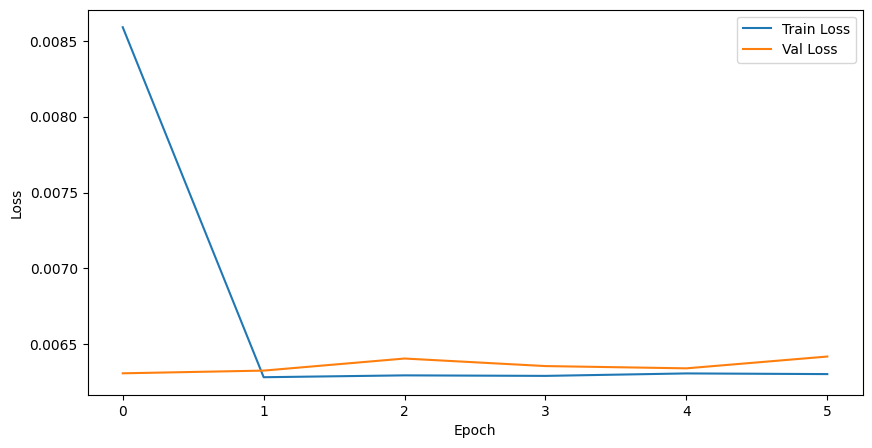

In [55]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

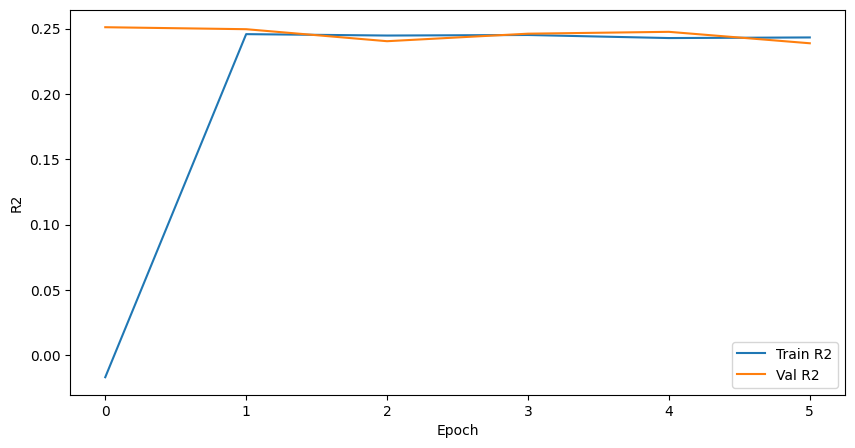

In [56]:
# plot the training and validation R^2 scores
plt.figure(figsize=(10, 5))
plt.plot(train_r2_list, label='Train R2')
plt.plot(val_r2_list, label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

# test case

In [47]:
# put the model in evaluation mode, turning drop_out off
model.eval()

# create a TensorDataset and a DataLoader for the validation set
test_dataset = TensorDataset(Xtest, ytest)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)
# make predictions on the test set
#with torch.no_grad():
  #  y_pred = model(X_test)

# iterate over the test set and compute the R^2 score
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_dataloader:
        output = model(x)
        y_true += y.tolist()
        y_pred += output.tolist()
r2 = r2_score(y_true, y_pred)
print(f"R^2 score on test set: {r2:.4f}")

R^2 score on test set: -70204.5461


 Negative values of R^2 can occur if the model fits the data very poorly and is worse than using a simple average.

# Plot scores and residuals

Scatter plot: Plot the predicted values against the actual values. This will give an idea of how well the model is fitting the data.

Residual plot: Plot the residuals (the difference between the predicted and actual values) against the predicted values. This can help identify patterns in the errors and determine if the model is underfitting or overfitting.

Histogram of residuals: Plot a histogram of the residuals to check if they are normally distributed. A normally distributed residual plot is a good sign that the model is performing well.

Learning curve: Plot the training and validation loss over time. This can help identify if the model is overfitting or underfitting, and if more data is needed for training.

Prediction intervals: Plot the predicted values with prediction intervals to visualize the uncertainty of the predictions.

In [ ]:
import seaborn as sns
model.eval()
y_pred = model(Xtest)

# calculate residuals
residuals = ytest - y_pred.detach().numpy()

# plot residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.scatter(ytest.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
plt.title("Scatter Plot")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [ ]:
residuals

In [ ]:
# separate the two outputs
ytest1 = ytest[:,0]
ytest2 = ytest[:,1]
y_pred1 = y_pred[:,0]
y_pred2 = y_pred[:,1]

# compute residuals
residuals1 = ytest1 - y_pred1.detach().numpy()
residuals2 = ytest2 - y_pred2.detach().numpy()

# compute standard deviation of residuals
residual_std1 = torch.std(residuals1)
residual_std2 = torch.std(residuals2)

# compute prediction intervals
lower_bound1 = y_pred1.detach().numpy() - residual_std1.numpy()
upper_bound1 = y_pred1.detach().numpy() + residual_std1.numpy()
lower_bound2 = y_pred2.detach().numpy() - residual_std2.numpy()
upper_bound2 = y_pred2.detach().numpy() + residual_std2.numpy()

# plot histogram of residuals for output 1
plt.hist(residuals1, bins=50)
plt.title('Histogram of Residuals for Output 1')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# plot histogram of residuals for output 2
plt.hist(residuals2, bins=50)
plt.title('Histogram of Residuals for Output 2')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# plot prediction intervals for output 1
plt.scatter(ytest1, y_pred1.detach().numpy())
plt.fill_between(np.arange(ytest1.min(), ytest1.max()+1),
                 lower_bound1.squeeze(),
                 upper_bound1.squeeze(),
                 alpha=0.2)
plt.plot(np.arange(ytest1.min(), ytest1.max()+1),
         np.arange(ytest1.min(), ytest1.max()+1),
         'r')
plt.title('Prediction Intervals for Output 1')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# plot prediction intervals for output 2
plt.scatter(ytest2, y_pred2.detach().numpy())
plt.fill_between(np.arange(ytest2.min(), ytest2.max()+1),
                 lower_bound2.squeeze(),
                 upper_bound2.squeeze(),
                 alpha=0.2)
plt.plot(np.arange(ytest2.min(), ytest2.max()+1),
         np.arange(ytest2.min(), ytest2.max()+1),
         'r')
plt.title('Prediction Intervals for Output 2')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'global_model.pt')

# Convert back to dataframe and plot

In [ ]:
def predModelNC(indata, model_fold, h, w):
    LKl = []
    Lepsl = []
    with torch.no_grad():
        for model in tqdm(model_fold):
            temp = model(torch.tensor(indata.astype(np.float32)).to(device))
            print(temp.shape)
            out = temp.detach().cpu().numpy()
            print(out.shape)
            LK = rearrange(out[:,0], '(h w) -> h w', h = h, w = w)
            Leps = rearrange(out[:,1], '(h w) -> h w', h = h, w = w)
            LKl.append(LK)
            Lepsl.append(Leps)
    LK, Leps =  np.array(LKl), np.array(Lepsl)
    return LK, Leps

In [ ]:
LK, Leps = predModelNC(X, model_fold, h, w)
print(LK.shape, Leps.shape)

LKm, Lepsm = np.mean(LK, axis = 0), np.mean(Leps, axis = 0) 
LKerr, Lepserr = np.std(LK, axis = 0), np.std(Leps, axis = 0) 
print(LKm.shape, LKerr.shape)